In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import datetime
from helpers import *
from implementations import *

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../../train.csv' # TODO: download train data and supply path here 
y_starting, tX_starting, ids = load_csv_data(DATA_TRAIN_PATH,sub_sample=False)

# Preprocessing

### Delete columns with low correlation

In [3]:
def drop_col(tX_starting):
    drop_columns=[]
    #for i in range(tX_starting.shape[1]):
    #    coeff=np.corrcoef(y,tX_starting[:,i])[0,1]
    #    if abs(coeff)<0.000:
    #        drop_columns.append(i)


    tX=np.delete(tX_starting,drop_columns,axis=1)
    return tX
    

In [4]:
def replace_nan(tX_starting,median=False):
    tX=tX_starting.copy()
    nan_position=[tX[:,[0,4,23]]!=-999][0]*1

    for col in range(tX.shape[1]):
        column=tX[:,col][tX[:,col]!=-999]
        if median==False:
            mean=column.mean()
            median=np.median(column)

        tX[:,col][tX[:,col]==-999]=median    
    
    return nan_position,tX,median
    

### Categorical variables

In [5]:
def categorical_variables(tX_starting):
    tX=tX_starting.copy()
    
    cat_variable=22
    values=[0,1,2]

    added_matrix=np.zeros([tX.shape[0],3])
    added_matrix[:,0]=np.array([tX[:,22]==0])
    added_matrix[:,1]=np.array([tX[:,22]==1])
    added_matrix[:,2]=np.array([tX[:,22]==2])
    
    tX=np.delete(tX,[22],axis=1)
    
    return added_matrix,tX

In [6]:
def before_poly(tX_starting,median=False):
    tX=drop_col(tX_starting)
    nan_position,tX,median=replace_nan(tX,median)
    added_matrix,tX=categorical_variables(tX)
    full_added_matrix=np.concatenate((added_matrix,nan_position),axis=1)
    return full_added_matrix,tX,median

### Polynomial regression

In [7]:
def build_poly(tX,degree,y,prod_to_exclude=False,train=True,columns_to_consider=False,exponential=False,cross_products=False,added_matrix_for_cross=False,threshold_power=0.0,threshold_cross=0.00,exclude=False):
    if not columns_to_consider:
        columns_to_consider=range(tX.shape[1])
    if not prod_to_exclude:
        prod_to_exclude=[]
    if exclude==False:
        exclude=[]
    dict_cross={}
    
    columns_to_consider=[x for x in columns_to_consider if x not in exclude]
    columns_to_consider=np.array(columns_to_consider)
    # Add power of the matrix
    final_list=[]
    for i in range(2,degree+1,1):
        #corr=np.corrcoef(tX[:,columns_to_consider]**i,y,rowvar=0)[:-1,-1]
        #cols=abs(corr)>threshold_power
        #cols=columns_to_consider[cols]
        cols=columns_to_consider
        tX=np.concatenate((tX,tX[:,cols]**i),axis=1)
    if exponential:
        tX=np.concatenate((tX,np.exp(tX[:,cols]/100)),axis=1)
        tX=np.concatenate((tX,np.exp(tX[:,cols]/80)),axis=1)
        tX=np.concatenate((tX,np.exp(tX[:,cols]/60)),axis=1)
        tX=np.concatenate((tX,np.exp(tX[:,cols]/50)),axis=1)
        tX=np.concatenate((tX,np.exp(tX[:,cols]/40)),axis=1)
        tX=np.concatenate((tX,np.exp(tX[:,cols]/20)),axis=1)
    if cross_products:
        if added_matrix_for_cross.any():
            # Add to columns to consider
            for i in range(tX.shape[1],tX.shape[1]+added_matrix_for_cross.shape[1]):
                columns_to_consider=np.append(columns_to_consider,i)
            # Concatenate
            tX=np.concatenate((tX,added_matrix_for_cross),axis=1)
            final_list.append(tX)
        start_cross=tX.shape[1]
        for i,col1 in enumerate(columns_to_consider):
            for j,col2 in enumerate(columns_to_consider):
                if j>i and (i,j) not in prod_to_exclude:
                    if train:
                        prod=tX[:,col1]*tX[:,col2]
                        corr=np.corrcoef(prod,y)[0,1]
                        if abs(corr)>threshold_cross:
                            final_list.append(prod.reshape([prod.shape[0],1]))
                            #print(start_cross,type(start_cross))
                            dict_cross[start_cross]=tuple([i,j])
                            start_cross+=1
                        else:
                            prod_to_exclude.append((i,j))
                    else:
                        prod=tX[:,col1]*tX[:,col2]
                        final_list.append(prod.reshape([prod.shape[0],1]))
        final_tuple=tuple(final_list)
        tX=np.concatenate(final_tuple,axis=1)
    return tX,prod_to_exclude,dict_cross


### Normalizing

In [8]:
def normalize(tX,mean=False,std=False,train=False):# Normalizing
    if train:
        mean=np.sum(tX,axis=0)/tX.shape[0]
        std=np.sqrt(np.sum(tX**2,axis=0)/tX.shape[0])
    tX=(tX-mean)/std
    if train:
        return tX,mean,std
    else:
        return tX

In [9]:
def add_ones(tX_starting):
    ones=np.ones(tX_starting.shape[0]).reshape([tX_starting.shape[0],1])
    tX=np.concatenate((tX_starting,ones),axis=1)
    return tX

In [10]:
def process_data(tX_starting,y,prod_to_exclude=False,train=True,mean=False,std=False,median=False,exclude=False):
    full_added_matrix,tX,median=before_poly(tX_starting,median)
    tX,prod_to_exclude,dict_cross=build_poly(tX,14,y,exclude=exclude,train=train,prod_to_exclude=prod_to_exclude,exponential=True,cross_products=True,added_matrix_for_cross=full_added_matrix,threshold_cross=0.0)
    if train:
        tX,mean,std=normalize(tX,train=True)
    else:
        tX=normalize(tX,mean,std,train=False)
    tX=add_ones(tX)
    
    if train:
        return tX,prod_to_exclude,mean,std,median,dict_cross
    else:
        return tX

In [ ]:
tX.shape

In [ ]:
prod_to_exclude

## Process data

In [11]:
tX=tX_starting.copy()
y=y_starting.copy()

In [12]:
exc=[]
tX=tX_starting.copy()
y=y_starting.copy()
tX,prod_to_exclude,mean,std,median,dict_cross=process_data(tX,y,train=True,exclude=exc)
#tX_test=process_data(tX_test,prod_to_exclude=prod_to_exclude,mean=mean,std=std,train=False,exclude=exc)

/home/stefano/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/stefano/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [13]:
tX.shape

(250000, 1175)

## Do your thing crazy machine learning thing here :) ...

In [ ]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    #np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)
k_indices=build_k_indices(y,4,1)
np.save("k_indices",k_indices)

In [ ]:
def cross_validation(y, x, k_indices, k, lambda_):
    """return the loss of ridge regression."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # get k'th subgroup in test, others in train: TODO
    # ***************************************************
    
    loss_tr=[]
    loss_te=[]
    ac_tr=[]
    ac_te=[]
    w_vector=[]
    for k_index in k_indices:
        
        x_test=x[k_index]
        y_test=y[k_index]
        
        mask = np.ones(x.shape[0], dtype=bool) # all elements included/True.
        mask[k_index] = False              # Set unwanted elements to False

        x_train=x[mask]
        y_train=y[mask]
        exc=[]
        x_train,prod_to_exclude,mean,std,median,dict_cross=process_data(x_train,y_train,train=True,exclude=exc)
        x_test=process_data(x_test,y_test,prod_to_exclude=prod_to_exclude,mean=mean,std=std,median=median,train=False,exclude=exc)
        #print(x_train.shape)

        w,mse=ridge_regression(y_train,x_train,lambda_)
        #w,mse=least_squares(y_train,x_train)
        w_vector.append(w)
        ac_tr.append(evaluate(y_train,x_train,w))
        ac_te.append(evaluate(y_test,x_test,w))
        
    #final_w=sum(w_vector)/4
        
    return ac_tr,ac_te,np.mean(ac_tr), np.mean(ac_te),w


In [ ]:
lamb=-3.44444444444e-05
#lamb=1e-04

In [ ]:
ac_tr,ac_te,mean_tr,mean_te,w=cross_validation(y,tX,k_indices,4,lamb)

In [ ]:
print(mean_te,mean_tr,ac_te,ac_tr)

In [28]:
# def least_squares(y, tx):
#     """calculate the least squares solution."""
#     # returns mse, and optimal weights
    
#     w=np.linalg.solve(tx.T.dot(tx),tx.T.dot(y))
#     mse=sum((y-tx.dot(w))**2)/tx.shape[0]
    
#     return mse,w

#w,loss=least_squares(y,tX)
print(evaluate(y,tX,w))
#
#print(evaluate(y_test,tX_test,w))

0.831764


In [26]:
lamb=-4.11111111e-05

In [27]:
# def ridge_regression(y, tx, lamb):
#     """implement ridge regression."""
#     # ***************************************************
#     # INSERT YOUR CODE HERE
#     # ridge regression: TODO
#     # ***************************************************
#     w=np.linalg.solve(tx.T.dot(tx)+lamb**2*np.identity(tx.shape[1]),tx.T.dot(y))
#     #mse=sum((y-tx.dot(w))**2)/tx.shape[0]
#     return 1,w

w,loss=ridge_regression(y,tX,lamb)

0
1
2
3
4
5
6
7
8
9


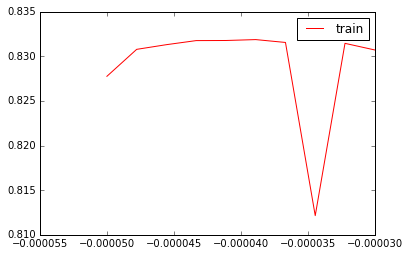

In [20]:
perc_tr=[]
perc_te=[]

lambdas = np.linspace(-0.00005,-0.00003,10)
for i,lamb in enumerate(lambdas):
    w,loss=ridge_regression(y,tX,lamb)
#     ac_tr,ac_te,mean_tr,mean_te,w=cross_validation(y,tX,k_indices,4,lamb)
#     perc_tr.append(mean_tr)
#     perc_te.append(mean_te)
#     print(mean_tr,mean_te,lamb)
    
    perc_tr.append(evaluate(y,tX,w))
    #perc_te.append(evaluate(y_test,tX_test,w))
    
    if i%1==0:
        print(i)

plt.plot(lambdas,perc_tr,label='train',color='r')
#plt.plot(lambdas,perc_te,label='test')
plt.legend()

In [22]:
perc_tr

[0.82775200000000004,
 0.83077200000000007,
 0.83129600000000003,
 0.83175200000000005,
 0.83176399999999995,
 0.83186399999999994,
 0.83154400000000006,
 0.81214799999999998,
 0.83144400000000007,
 0.830704]

In [23]:
lambdas

array([ -5.00000000e-05,  -4.77777778e-05,  -4.55555556e-05,
        -4.33333333e-05,  -4.11111111e-05,  -3.88888889e-05,
        -3.66666667e-05,  -3.44444444e-05,  -3.22222222e-05,
        -3.00000000e-05])

In [ ]:
print(np.amax(perc_te))
print(np.median(perc_te))
b=np.argmax(perc_te)
best_lamb=lambdas[b]

mse,w=ridge_regression(y,tX,best_lamb)
w.shape
best_lamb



In [ ]:
lamb=3.35e-05
lamb

In [ ]:
perc_te[24]

## Best so far
- Degree 10 - 4 exp - all done, ridge regression: 0.82956
- Degree 10 - 3 exp - all done, ridge regression: 0.829008
- Degree 14 - 2 exp - all done, ridge regression: 0.82896
- Degree 12 - 2 exp - all done, ridge regression: 0.828936
- Degree 12 - all done, ridge regression: 0.828784
- Degree 10 - 2 exp - all done, ridge regression: 0.828408
- Degree 10 - exp - all done, ridge regression: 0.827816
- Degree 10 - all done, ridge regression: 0.82717600000000002
- Degree 6 - all done, ridge regression: 0.81543199999999993
- Degree 8 - all done, ridge regression: 0.82291999999999998

In [ ]:
cor=np.corrcoef(tX,rowvar=0)

In [ ]:
plt.rcParams['figure.figsize'] = 25, 18

In [ ]:
plt.matshow(cor)


In [ ]:
def main_loop():
    list_tr=[]
    list_te=[]
    tX,tX_test,y,y_test=split_data(tX_starting,y_starting,0.5,1)
    exclude_list=[]
    tX,prod_to_exclude,mean,std,dict_cross=process_data(tX,train=True,exclude=exclude_list)
    tX_test=process_data(tX_test,prod_to_exclude=prod_to_exclude,mean=mean,std=std,train=False,exclude=exclude_list)
    for i in range(tX.shape[1]):
        if i%10==0:
            print(i)
        tX_new=np.delete(tX,i,axis=1)
        tX_test_new=np.delete(tX_test,i,axis=1)
    
        mse,w=least_squares(y,tX_new)
        list_tr.append(evaluate(y,tX_new,w))
        list_te.append(evaluate(y_test,tX_test_new,w))
    return list_tr,list_te
list_tr,list_te=main_loop()

In [ ]:
exclude_list=list(sum([np.array(list_te)>0.8208]))

In [ ]:
for i,num in enumerate(exclude_list):
    if num==1:
        exclude_list[i]=i
exclude_list=[x for x in exclude_list if x!=0]

In [ ]:
print(exclude_list)

In [ ]:
tX=np.delete(tX,exclude_list,axis=1)

In [ ]:
tX_test=np.delete(tX_test,exclude_list,axis=1)

In [ ]:
tX.shape


In [ ]:
# Basic implementation of logistic regression using the least squares
def logistic_regression(y,tx,tx_test,threshold=0.5):
    mse,w=least_squares(y,tx)
    
    y_prev=tx.dot(w)
    y_prev=1/(1+np.exp(-y_prev))
    output_train=np.ones(y_prev.shape[0])
    output_train[np.where(y_prev<threshold)] = -1
    
    y_test=tx_test.dot(w)
    y_test=1/(1+np.exp(-y_test))
    output_test=np.ones(y_test.shape[0])
    output_test[np.where(y_test<threshold)] = -1
    
    return output_train,output_test

thresholds=np.linspace(0.48,0.52,101)
perc_log_tr=[]
perc_log_te=[]
for threshold in thresholds:
    output_train,output_test=logistic_regression(y_train,tX_train,tX_test,threshold)
    perc_log_tr.append(evaluate_prediction(output_train,y_train))
    perc_log_te.append(evaluate_prediction(output_test,y_test))

    
plt.plot(thresholds,perc_log_tr,'r',label='Train')
plt.plot(thresholds,perc_log_te,'b',label='Test')
plt.legend()

## Generate predictions and save ouput in csv format for submission:

In [29]:
DATA_TEST_PATH = '../../test.csv' # TODO: download train data and supply path here 
_, tX_final_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [30]:
tX_final=process_data(tX_final_test,y=y,prod_to_exclude=prod_to_exclude,mean=mean,std=std,median=median,train=False)

In [31]:
tX_final.shape

(568238, 1175)

In [32]:
OUTPUT_PATH = '../../predictions.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(w, tX_final)
#y_train,y_test = logistic_regression(y_train,tX_train,tX_final_test,0.48)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)
print(y_pred)

[-1. -1.  1. ...,  1. -1. -1.]
